# Image Classification Project 6
Choose three classes from the Open Images Dataset. Train a neural net that is able to classify images into these three categories.



In [1]:
classes = ['Cat', 'Dog', 'Person']

## Dataset
https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection

## Base model
VGG 19

In [43]:
# imports
import os
import shutil
from openimages import download
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Conv2D, LeakyReLU
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Path to the directory where the images are stored
base_dir = './dataset'

# Check if the directory exists
if os.path.exists(base_dir):
    # Delete the directory and its contents
    shutil.rmtree(base_dir)

# number of images per class
n_images = 100

# Download images for each class using Open Images
download.download_dataset(
    dest_dir=base_dir,
    class_labels=classes,
    limit=n_images
)

2023-06-03  19:48:22 INFO Downloading 100 train images for class 'cat'
100%|██████████| 100/100 [00:05<00:00, 19.53it/s]
2023-06-03  19:48:27 INFO Downloading 100 train images for class 'dog'
100%|██████████| 100/100 [00:04<00:00, 20.47it/s]
2023-06-03  19:48:33 INFO Downloading 100 train images for class 'person'
100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


{'cat': {'images_dir': './dataset\\cat\\images'},
 'dog': {'images_dir': './dataset\\dog\\images'},
 'person': {'images_dir': './dataset\\person\\images'}}

## Task
1. Preparation: Split dataset into a 70/30 Train/test split


In [4]:
# Define parameters for the loader
img_height = 224
img_width = 224

# Load the training data
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.3)  # set validation split

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='training')  # set as training data

# Load the validation data
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='validation')  # set as validation data

Found 210 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


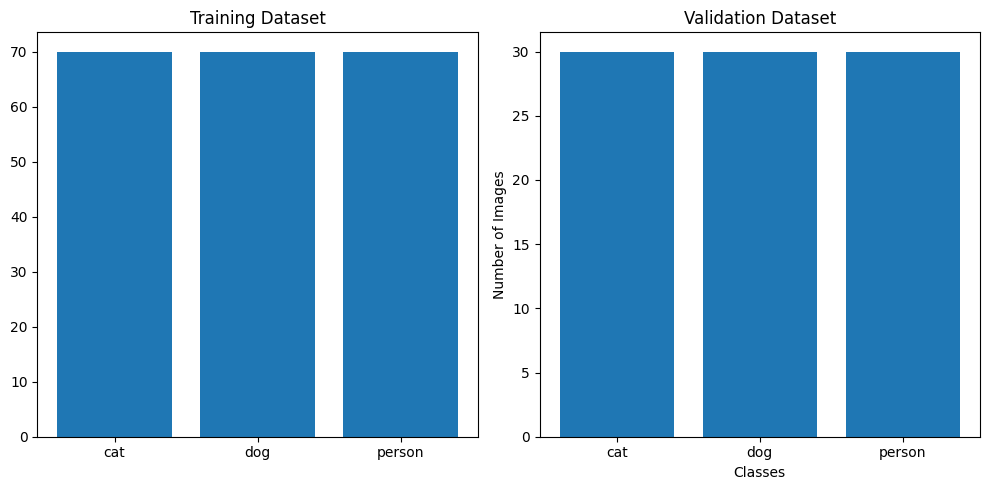

In [5]:
# Get the class labels and the number of images per class from the generators
class_labels = train_generator.class_indices
n_images_per_class = train_generator.classes.shape[0] // len(class_labels)

# Plot the datasets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training dataset
train_generator.class_indices = class_labels
class_counts_train = train_generator.classes
class_counts_train = [class_counts_train[class_counts_train == i].shape[0] for i in range(len(class_labels))]
axes[0].bar(class_labels.keys(), class_counts_train)
axes[0].set_title('Training Dataset')

# Plot the validation dataset
validation_generator.class_indices = class_labels
class_counts_val = validation_generator.classes
class_counts_val = [class_counts_val[class_counts_val == i].shape[0] for i in range(len(class_labels))]
axes[1].bar(class_labels.keys(), class_counts_val)
axes[1].set_title('Validation Dataset')

# Set the labels and show the plot
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


2. Train a VGG19 network from scratch (randomly initialized weights) and estimate the testset accuracy.

In [6]:
# Load a VGG19 model with random initialized weights
base_model = VGG19(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
plain_model = Sequential()
# Add the base model as the first layer
plain_model.add(base_model)
# Flatten the output of the base model
plain_model.add(Flatten())
# Add the final output layer with softmax activation
plain_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
plain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
plain_history = plain_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

plain_model.save("plain_model_raw_data.h5")

Epoch 1/10
7/7 [==============================] - 257s 38s/step - loss: 1.1065 - accuracy: 0.3429 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 2/10
7/7 [==============================] - 246s 34s/step - loss: 1.0990 - accuracy: 0.3333 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 3/10
7/7 [==============================] - 196s 28s/step - loss: 1.1002 - accuracy: 0.2619 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 4/10
7/7 [==============================] - 218s 32s/step - loss: 1.0989 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/10
7/7 [==============================] - 240s 34s/step - loss: 1.0988 - accuracy: 0.2810 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 6/10
7/7 [==============================] - 222s 32s/step - loss: 1.0988 - accuracy: 0.3238 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/10
7/7 [==============================] - 228s 35s/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 8/10
7/7 [====

3. Use an imagenet pretrained VGG19 network, train the model and estimate the testset accuracy.

In [8]:
# Load a VGG19 model with random initialized weights
pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
trained_model = Sequential()
# Add the base model as the first layer
trained_model.add(pre_trained_model)
# Flatten the output of the base model
trained_model.add(Flatten())
# Add the final output layer with softmax activation
trained_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
trained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
trained_history  = trained_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

trained_model.save("trained_model_raw_data.h5")

Epoch 1/10
7/7 [==============================] - 250s 36s/step - loss: 25.1956 - accuracy: 0.3048 - val_loss: 1.2380 - val_accuracy: 0.3333
Epoch 2/10
7/7 [==============================] - 238s 34s/step - loss: 1.2003 - accuracy: 0.3286 - val_loss: 1.1015 - val_accuracy: 0.3333
Epoch 3/10
7/7 [==============================] - 239s 34s/step - loss: 1.1588 - accuracy: 0.3143 - val_loss: 1.0982 - val_accuracy: 0.3778
Epoch 4/10
7/7 [==============================] - 237s 34s/step - loss: 1.1086 - accuracy: 0.2714 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/10
7/7 [==============================] - 238s 34s/step - loss: 1.1061 - accuracy: 0.3143 - val_loss: 1.0973 - val_accuracy: 0.3333
Epoch 6/10
7/7 [==============================] - 237s 34s/step - loss: 1.1047 - accuracy: 0.3333 - val_loss: 1.0980 - val_accuracy: 0.3333
Epoch 7/10
7/7 [==============================] - 237s 34s/step - loss: 1.0981 - accuracy: 0.3905 - val_loss: 1.0977 - val_accuracy: 0.3333
Epoch 8/10
7/7 [===

#### The differences in loss and accuracy of the plain and pre trained network over the first 10 epochs

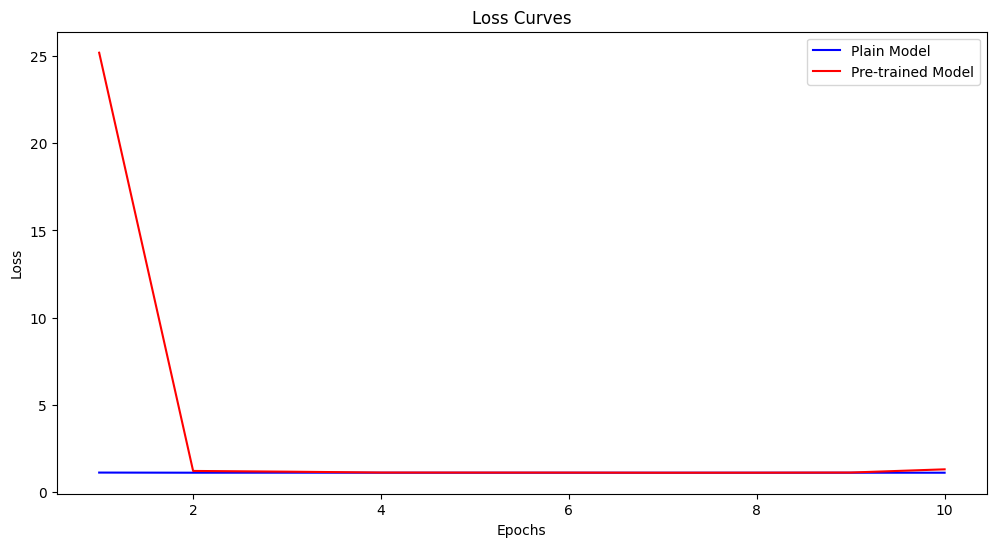

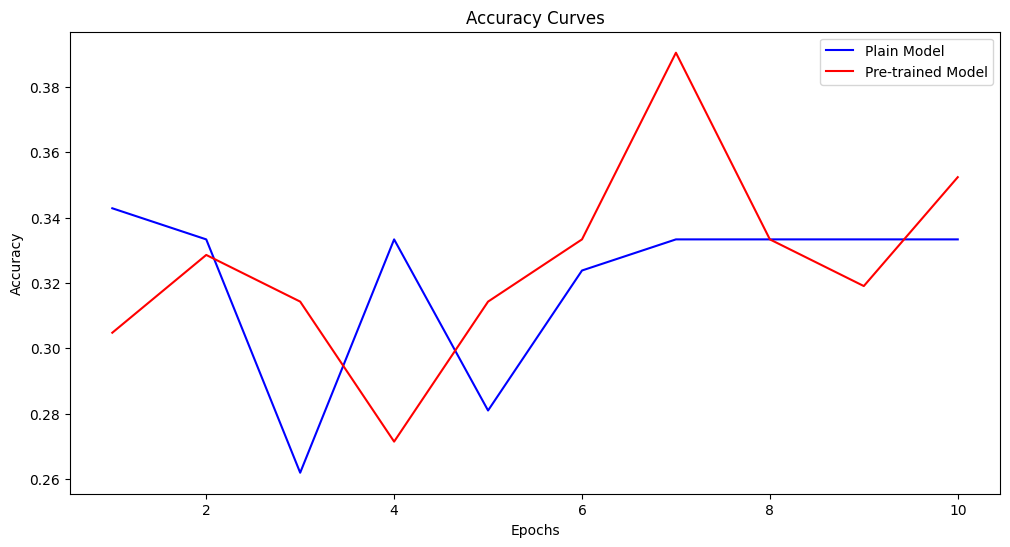

In [9]:
# Extract loss and accuracy values for both models
plain_loss = plain_history.history['loss']
plain_accuracy = plain_history.history['accuracy']
trained_loss = trained_history.history['loss']
trained_accuracy = trained_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_loss, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_loss, 'r-', label='Pre-trained Model')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_accuracy, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_accuracy, 'r-', label='Pre-trained Model')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4. Data cleansing: Remove “bad” images from the dataset. Which did you remove? How many? Discuss results.

5. Add data augmentation: 
    - Random flip
    - Random contrast
    - Random translation

In [38]:
def custom_preprocessing(image):
    # Generate a random contrast factor
    contrast_factor = np.random.uniform(0.8, 1.2)
    # Apply contrast adjustment
    image = image * contrast_factor
    image = tf.clip_by_value(image, 0.0, 1.0)  # Clip values to the [0, 1] range
    return image

In [41]:
# Define parameters for the loader
batch_size = 10
img_height = 224
img_width = 224

# Load the training data
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.3,
        horizontal_flip=True,  # Apply random flip
        vertical_flip=True,  # Apply random flip
        width_shift_range=0.2,  # Apply random translation
        height_shift_range=0.2,  # Apply random translation
        preprocessing_function=custom_preprocessing # Apply random contrast
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # set as training data

# Load the validation data
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # set as validation data

Found 210 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


#### Train both models again

In [44]:
# Load a VGG19 model with random initialized weights
base_model = VGG19(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
plain_model = Sequential()
# Add the base model as the first layer
plain_model.add(base_model)
# Flatten the output of the base model
plain_model.add(Flatten())
# Add the final output layer with softmax activation
plain_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
plain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
plain_history = plain_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

plain_model.save("plain_model_augmentated_data.h5")

Epoch 1/10
21/21 [==============================] - 246s 11s/step - loss: 1.1005 - accuracy: 0.2762 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/10
 7/21 [=========>....................] - ETA: 2:22 - loss: 1.0995 - accuracy: 0.3429

KeyboardInterrupt: 

In [ ]:
# Load a VGG19 model with random initialized weights
pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
trained_model = Sequential()
# Add the base model as the first layer
trained_model.add(pre_trained_model)
# Flatten the output of the base model
trained_model.add(Flatten())
# Add the final output layer with softmax activation
trained_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
trained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
trained_history  = trained_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

trained_model.save("trained_model_augmentated_data.h5")

In [ ]:
# Extract loss and accuracy values for both models
plain_loss = plain_history.history['loss']
plain_accuracy = plain_history.history['accuracy']
trained_loss = trained_history.history['loss']
trained_accuracy = trained_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_loss, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_loss, 'r-', label='Pre-trained Model')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_accuracy, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_accuracy, 'r-', label='Pre-trained Model')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6. Rebuild VGG19. After layer block4_conv4 (25, 25, 512):
    - Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    - Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    - Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    - Freeze conv2 layers and before

In [45]:
# Load a VGG19 model with random initialized weights
base_model = VGG19(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
plain_model = Sequential()

# Add layers until block4_conv4
for layer in base_model.layers:
    plain_model.add(layer)
    if layer.name == 'block4_conv4':
        break

# Freeze the layers before block2_conv2
freeze = True
for layer in plain_model.layers:
    if layer.name == 'block2_conv2':
        freeze = False
    layer.trainable = not freeze

# Add the inception layer with dimensionality reduction
plain_model.add(Conv2D(512, (1, 1), activation='relu'))
plain_model.add(Conv2D(256, (1, 1), activation='relu'))
plain_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

# Add the conv layer with kernel 1x1, filters 1024, padding valid, stride 1, activation leaky relu
plain_model.add(Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1)))

# Add the conv layer with kernel 3x3, filters 1024, padding same, stride 1, activation relu
plain_model.add(Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu'))

# Flatten the output of the last added layer
plain_model.add(Flatten())

# Add the final output layer with softmax activation
plain_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
plain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
plain_history = plain_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

plain_model.save("plain_Rebuild_VGG19_model_augmentated_data.h5")

Epoch 1/10
 2/21 [=>............................] - ETA: 3:38 - loss: 1.0999 - accuracy: 0.2000

KeyboardInterrupt: 

In [ ]:
# Load a VGG19 model with random initialized weights
pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
trained_model = Sequential()

# Add layers until block4_conv4
for layer in pre_trained_model.layers:
    trained_model.add(layer)
    if layer.name == 'block4_conv4':
        break

# Freeze the layers before block2_conv2
freeze = True
for layer in trained_model.layers:
    if layer.name == 'block2_conv2':
        freeze = False
    layer.trainable = not freeze

# Add the inception layer with dimensionality reduction
trained_model.add(Conv2D(512, (1, 1), activation='relu'))
trained_model.add(Conv2D(256, (1, 1), activation='relu'))
trained_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

# Add the conv layer with kernel 1x1, filters 1024, padding valid, stride 1, activation leaky relu
trained_model.add(Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1)))

# Add the conv layer with kernel 3x3, filters 1024, padding same, stride 1, activation relu
trained_model.add(Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu'))

# Flatten the output of the last added layer
trained_model.add(Flatten())

# Add the final output layer with softmax activation
trained_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
trained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
trained_history  = trained_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

trained_model.save("trained_Rebuild_VGG19_model_augmentated_data.h5")

In [ ]:
# Extract loss and accuracy values for both models
plain_loss = plain_history.history['loss']
plain_accuracy = plain_history.history['accuracy']
trained_loss = trained_history.history['loss']
trained_accuracy = trained_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_loss, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_loss, 'r-', label='Pre-trained Model')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_accuracy, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_accuracy, 'r-', label='Pre-trained Model')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7. Test a few of your own images and present the results

8. Answer the following questions:
    - What accuracy can be achieved? What is the accuracy of the train vs. test set?
    - On what infrastructure did you train it? What is the inference time?
    - What are the number of parameters of the model?
    - Which categories are most likely to be confused by the algorithm? Show results in a confusion matrix.